# Basic RNA circuit simulation 



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bioreaction.simulation.basic_sim import convert_model

import jax
import numpy as np
import pandas as pd
import os
import sys

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-paper')
os.environ["TF_CPP_MIN_LOG_LOVEL"] = "0"
jax.config.update('jax_platform_name', 'gpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from src.utils.data.data_format_tools.common import load_json_as_dict
from src.utils.common.setup_new import prepare_config, construct_circuit_from_cfg
from src.utils.circuit.agnostic_circuits.circuit_manager_new import CircuitModeller
from src.utils.evolution.evolver import load_mutations
from src.utils.misc.type_handling import flatten_listlike
from src.utils.modelling.physical import equilibrium_constant_reparameterisation
from tests_local.shared import five_circuits

config = load_json_as_dict('../tests_local/configs/simple_circuit.json')


In [28]:
{
    "precision_wrt_species-6": [
        "1.3891953",
        "30.319056",
        "25.585289",
        "5.4617434",
        "5.4146256",
        "5.367322",
        "1.0",
        "30.296034",
        "44.328964"
    ],
    "sensitivity_wrt_species-6": [
        "0.8160268",
        "0.16067664",
        "0.152413",
        "0.18309173",
        "0.18468498",
        "0.1882373",
        "1.0",
        "0.043004103",
        "0.04353581"
    ]}


def p(final, initial, signal_f, signal_i):
    return 1 / np.divide(
        (final - initial) / initial,
        (signal_f - signal_i) / signal_i
    )

final, initial, signal_f, signal_i = (173.34004, 157.3838, 419.0314, 76.26714)
p(final, initial, signal_f, signal_i)

44.32895955511785

In [33]:


def calculate_precision(output_diff, starting_states, signal_diff, signal_0) -> np.ndarray:
    denom = np.where(signal_0 != 0, signal_diff / signal_0, 1)
    numer = np.where((starting_states != 0).astype(int),
                      output_diff / starting_states, 1)
    precision = np.absolute(np.divide(
        numer, denom))
    return np.divide(1, precision)


def get_precision(signal_idx: int, starting_states, steady_states):
    if signal_idx is None:
        return None
    signal_0 = starting_states[signal_idx]
    signal_1 = steady_states[signal_idx]

    signal_diff = signal_1 - signal_0
    output_diff = steady_states - starting_states

    return calculate_precision(output_diff, starting_states, signal_diff, signal_0)


signal_diff = signal_f - signal_i
output_diff = final - initial
calculate_precision(output_diff, np.expand_dims(initial, axis=0), signal_diff, signal_i)
denom = np.where(signal_i != 0, signal_diff / signal_i, 1)

numer = np.where((np.expand_dims(initial, axis=0) != 0).astype(int),
                    output_diff / initial, 1)

numer
denom


array(4.49425873)

In [3]:



def update_model_rates(model, a=None, d=None, ka=None, kd=None):
    for i, r in enumerate(model.reactions):
        if not r.input:  # 0 -> RNA
            if a is not None:
                model.reactions[i].forward_rate = a[model.species.index(
                    r.output[0])]
                model.reactions[i].reverse_rate = 0
        elif not r.output:  # RNA -> 0
            if d is not None:
                model.reactions[i].forward_rate = d[model.species.index(
                    r.input[0])]
                model.reactions[i].reverse_rate = 0
        else: # unbound RNA -> bound RNA
            if ka is not None:
                model.reactions[i].forward_rate = ka[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
            if kd is not None:
                model.reactions[i].reverse_rate = kd[model.species.index(r.input[0]),
                                                     model.species.index(r.input[1])]
    return model


def make_params(model, scale_rates=True):
    sim_model = convert_model(model)

    if scale_rates:
        m = np.max([sim_model.forward_rates.max(), sim_model.reverse_rates.max()])
    else:
        m = 1
    inputs = sim_model.inputs
    outputs = sim_model.outputs
    forward_rates = sim_model.forward_rates/m
    reverse_rates = sim_model.reverse_rates/m
    return inputs, outputs, forward_rates, reverse_rates, m

Use the 5 tester circuits :)

In [4]:
config = prepare_config(config)
config['include_prod_deg'] = False
config['simulation']['use_rate_scaling'] = False

q = 1
p = 1
config['molecular_params_factor'] = p
config['simulation']['interaction_factor'] = 1
config['molecular_params']['creation_rate'] = config['molecular_params']['creation_rate'] * q
config['molecular_params']['creation_rate' + '_per_molecule'] = config['molecular_params']['creation_rate' + '_per_molecule'] * q
# config['simulation']['dt'] = 0.1
# config['molecular_params']['creation_rate'] = config['molecular_params']['creation_rate'] * p
# config['molecular_params']['degradation_rate'] = config['molecular_params']['degradation_rate'] * p

In [5]:
circuits, config, result_writer = five_circuits(config)


xla_bridge.py:backends():355: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker:  INFO
xla_bridge.py:backends():355: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA Host INFO
xla_bridge.py:backends():355: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():355: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this. INFO
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of ../tests_local/configs/binding_rates_dissociation/0_weak_binding_rates_dissociation.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experi

In [6]:


def load_circuit(top_dir, circuit_name, config):
    dp = os.path.join(top_dir, 'circuits', circuit_name + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': os.path.join(top_dir, 'binding_rates_dissociation', circuit_name + '_' + 'binding_rates_dissociation' + '.csv'),
                    'eqconstants': os.path.join(top_dir, 'eqconstants', circuit_name + '_' + 'eqconstants' + '.csv'),
                    'energies': os.path.join(top_dir, 'energies', circuit_name + '_' + 'energies' + '.csv'),
                    'binding_sites': os.path.join(top_dir, 'binding_sites', circuit_name + '_' + 'binding_sites' + '.csv')}

    return construct_circuit_from_cfg({
        'data_path': dp,
        'interactions': interactions
    }, config)


# tester_circuit = load_circuit(top_dir='data/ensemble_mutation_effect_analysis/2023_04_04_092945/generate_species_templates',
#              circuit_name='toy_mRNA_circuit_1844', config=config)


# tester_circuits = []
# for name in ['toy_mRNA_circuit_21566', 'toy_mRNA_circuit_24706', 'toy_mRNA_circuit_19768', 'toy_mRNA_circuit_2983', 'toy_mRNA_circuit_22658']:
#     fn = os.path.join('..', 'data/ensemble_mutation_effect_analysis/2023_04_11_192013/mutation_effect_on_interactions_signal', name, 'mutations.csv')
#     tester_circuit = load_circuit(top_dir='data/ensemble_mutation_effect_analysis/2023_04_04_092945/generate_species_templates',
#                                         circuit_name=name, config=config)
#     tester_circuit = load_mutations(tester_circuit, fn)
#     tester_circuits.append(tester_circuit)

# config['interactions'] = {}
# config['interactions'] = None
# tester_circuit = construct_circuit_from_cfg(
#     {'data_path': '../tester.fasta'}, config)
# [circuits.append(tester_circuit) for tester_circuit in tester_circuits]


In [7]:


def load_fake_circuit(eqconstants):
    top_dir = 'data/ensemble_mutation_effect_analysis/2023_04_04_092945/generate_species_templates'
    circuit_name = 'toy_mRNA_circuit_1844'
    some_circuit = os.path.join(top_dir, 'circuits', circuit_name + '.fasta')

    k_a = config['molecular_params']['association_binding_rate' + '_per_molecule']

    def eqconstant_to_rates(eqconstants):
        """ Translate the equilibrium rate of binding to
        the rate of binding (either association or dissociation
        rate - in this case dissociation). Input in mol, output in molecules:
        k_a: binding rate per Ms
        eqconstants: unitless but in terms of mol
        k_d: unbinding rate per s"""
        k_d = np.divide(k_a, eqconstants)
        return k_a*np.ones_like(k_d), k_d

    binding_rates_dissociation = eqconstant_to_rates(eqconstants)[1]

    labels = ['RNA_0', 'RNA_1', 'RNA_2']
    pd.DataFrame(eqconstants, columns=labels, index=labels).to_csv(
        'eqconstants.csv', index=None)
    pd.DataFrame(binding_rates_dissociation, columns=labels, index=labels).to_csv('binding_rates_dissociation.csv', index=None)

    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': os.path.join('explanations', 'binding_rates_dissociation' + '.csv'),
                    'eqconstants': os.path.join('explanations', 'eqconstants' + '.csv'),
                    'energies': os.path.join(top_dir, 'energies', circuit_name + '_' + 'energies' + '.csv'),
                    'binding_sites': os.path.join(top_dir, 'binding_sites', circuit_name + '_' + 'binding_sites' + '.csv')}
    return construct_circuit_from_cfg({
        'data_path': some_circuit,
        'interactions': interactions
    }, config)


eqconstants_4337 = np.array([[1e2, 1e2, 5e0],
                             [1e2, 1e-02, 1e2],
                             [5e0, 1e2, 1e-02]])

# tester_circuit = load_fake_circuit(eqconstants_4337)
tester_circuit1 = load_fake_circuit(np.ones((3,3)))
tester_circuit1.name = 'K_1'
tester_circuit2 = load_fake_circuit(np.ones((3,3)) * 0.5)
tester_circuit2.name = 'K_05'
# tester_circuit2 = load_fake_circuit(np.ones((3,3)) * 0)
# tester_circuit2.name = 'K_0'

circuits.append(tester_circuit1)
circuits.append(tester_circuit2)


interactions.py:isolate_circuit_name():122: Could not find circuit name in explanations/binding_rates_dissociation.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of explanations/binding_rates_dissociation.csv WARNING
interactions.py:isolate_circuit_name():122: Could not find circuit name in explanations/eqconstants.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of explanations/eqconstants.csv WARNING
interactions.py:isolate_circuit_name():122: Could not find circuit name in explanations/binding_rates_dissociation.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid experiment directory instead of explanations/binding_rates_dissociation.csv WARNING
interactions.py:isolate_circuit_name():122: Could not find circuit name in explanations/eqconstants.csv WARNING
experiment_loading.py:load_units():35: Units unknown - supply a valid exper

In [8]:
config['molecular_params']['association_binding_rate' + '_per_molecule']

0.00150958097

In [9]:

circuit_modeller = CircuitModeller(result_writer=result_writer, config=config)
circuits = circuit_modeller.batch_circuits(
    circuits=circuits, methods={"compute_interactions": {}},
    batch_size=config['simulation']['batch_size'])
i = -1
# for i in range(len(circuits)):
#     circuits[i].interactions.binding_rates_association = circuits[i].interactions.binding_rates_association * q
#     circuits[i].interactions.binding_rates_dissociation = circuits[i].interactions.binding_rates_dissociation * q
#     circuits[i].update_species_simulated_rates(circuits[i].interactions)


simulator.py:check_IntaRNA_path():117: Could not detect IntaRNA on system: CompletedProcess(args='which IntaRNA', returncode=1, stdout='', stderr='') WARNING
circuit_manager_new.py:batch_circuits():574: 	From 7 circuits, a total of 7 mutated circuits will be simulated. WARNING
circuit_manager_new.py:batch_circuits():581: 		Starting new round of viable circuits (0 - 7 / 7) WARNING
circuit_manager_new.py:batch_circuits():599: 		Making subcircuits 0 - 7 took 1.1e-05s WARNING
circuit_manager_new.py:batch_circuits():605: 	Batching 0 - 100 circuits (out of 0 - 7 (total: 7)) (Circuits: 0 - 7 of 7) WARNING
circuit_manager_new.py:run_batch():636: 		Running 7 Subcircuits - 0_weak: compute_interactions WARNING
circuit_manager_new.py:run_batch():672: 		Method compute_interactions took 0.026523s WARNING
circuit_manager_new.py:batch_circuits():619: Single batch: 0:00:00.027488 
Projected time: 0.027487999999999995s 
Total time: 0:00:00.027498 WARNING


In [10]:
circuits[i].interactions.binding_rates_dissociation

array([[0.00301916, 0.00301916, 0.00301916],
       [0.00301916, 0.00301916, 0.00301916],
       [0.00301916, 0.00301916, 0.00301916]])

In [11]:
circuits[i].interactions.binding_rates_association

array([[0.00150958, 0.00150958, 0.00150958],
       [0.00150958, 0.00150958, 0.00150958],
       [0.00150958, 0.00150958, 0.00150958]])

In [12]:
config['molecular_params']['creation_rate']

2.35

In [13]:
config['molecular_params']['degradation_rate']


0.01175

In [14]:

circuits = circuit_modeller.batch_circuits(
    circuits=circuits, 
    batch_size=config['simulation']['batch_size'],
    methods={
        # "compute_interactions": {},
        "init_circuits": {'batch': True},
        'simulate_signal_batch': {'ref_circuit': None,
                                  'batch': config['simulation']['use_batch_mutations']},
        'write_results': {'no_visualisations': False, # config['experiment']['no_visualisations'],
                          'no_numerical': False} #config['experiment']['no_numerical']}
    }
)

circuit_manager_new.py:batch_circuits():574: 	From 7 circuits, a total of 7 mutated circuits will be simulated. WARNING
circuit_manager_new.py:batch_circuits():581: 		Starting new round of viable circuits (0 - 7 / 7) WARNING
circuit_manager_new.py:batch_circuits():599: 		Making subcircuits 0 - 7 took 1.2e-05s WARNING
circuit_manager_new.py:batch_circuits():605: 	Batching 0 - 100 circuits (out of 0 - 7 (total: 7)) (Circuits: 0 - 7 of 7) WARNING
circuit_manager_new.py:run_batch():636: 		Running 7 Subcircuits - 0_weak: init_circuits WARNING


Steady states:  100  iterations.  1  left to steady out.  0:00:01.557737


circuit_manager_new.py:run_batch():672: 		Method init_circuits took 3.043806s WARNING
circuit_manager_new.py:run_batch():636: 		Running 7 Subcircuits - 0_weak: simulate_signal_batch WARNING
circuit_manager_new.py:prepare_internal_funcs():497: Signal differs between circuits, but only first signal used for simulation. WARNING


Done:  0:00:02.882271


circuit_manager_new.py:simulate_signal_batch():345: 		Simulating signal took 1.909875s WARNING


Done:  0:00:01.891658


circuit_manager_new.py:simulate_signal_batch():403: 		Calculating analytics took 1.460325s WARNING
circuit_manager_new.py:run_batch():672: 		Method simulate_signal_batch took 3.582746s WARNING
circuit_manager_new.py:run_batch():636: 		Running 7 Subcircuits - 0_weak: write_results WARNING
circuit_manager_new.py:run_batch():672: 		Method write_results took 2.26354s WARNING
circuit_manager_new.py:batch_circuits():619: Single batch: 0:00:08.892462 
Projected time: 8.892462s 
Total time: 0:00:08.892472 WARNING


## Plot results

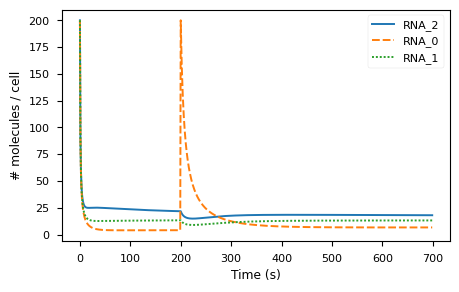

In [15]:


chosen_circuit = circuits[4]
data_fn_ste = os.path.join(result_writer.write_dir, chosen_circuit.name, 'steady_states_data.csv')
data_fn_sig = os.path.join(result_writer.write_dir, chosen_circuit.name, 'signal_data.csv')
data = pd.concat([
    pd.read_csv(data_fn_ste, names=[s.name for s in chosen_circuit.model.species]),
    pd.read_csv(data_fn_sig, names=[s.name for s in chosen_circuit.model.species])
]).reset_index()

plt.figure(figsize=(5,3))
sns.lineplot(data[[s.name for s in set(flatten_listlike(chosen_circuit.get_input_species()))]])
plt.ylabel('# molecules / cell')
plt.xlabel('Time (s)')
plt.savefig('circ4.svg')
